<a href="https://colab.research.google.com/github/areeba-png/GeoVegSindh/blob/main/Clean_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install streamlit google-auth earthengine-api folium
!pip install pyngrok
!pip install streamlit-folium
!pip install --upgrade streamlit
!pip install --upgrade earthengine-api
!pip uninstall earthengine-api -y
!pip install earthengine-api geemap --upgrade
!pip install geemap
!streamlit run your_script.py


Found existing installation: earthengine-api 1.5.4
Uninstalling earthengine-api-1.5.4:
  Successfully uninstalled earthengine-api-1.5.4
  Using cached earthengine_api-1.5.4-py3-none-any.whl.metadata (2.1 kB)
Using cached earthengine_api-1.5.4-py3-none-any.whl (459 kB)


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: your_script.py


In [ ]:
# Import the ngrok module
from pyngrok import ngrok

# Set up ngrok authentication
ngrok.set_auth_token('2oN4nqQFM630omoOfRmGkCGFrIH_3bjieEHQHgBQfcHoeeqzs')


In [ ]:
# Cell 3: Set Up ngrok Authentication
ngrok.set_auth_token('2oN4nqQFM630omoOfRmGkCGFrIH_3bjieEHQHgBQfcHoeeqzs')

In [ ]:
import os

# Create the .streamlit directory
os.makedirs("/content/.streamlit", exist_ok=True)

# Write your Google Earth Engine JSON key into the secrets.toml file
with open("/content/.streamlit/secrets.toml", "w") as f:
    f.write("""
    [general]
    json_key = "/content/Service Key.json"
    """)


In [ ]:
import ee

service_account = "vegelaticsproject@ee-areebe034.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(service_account, "/content/Service Key.json")
ee.Initialize(credentials)


In [ ]:
%%writefile ndvi_app.py
import streamlit as st
import ee
import folium
from streamlit_folium import folium_static
from datetime import datetime, timedelta
import json
from google.oauth2 import service_account
import geopandas as gpd
import pandas as pd
import requests
import branca.colormap as cm
import tempfile
import zipfile
import os
import io
from folium import plugins
from shapely.geometry import Point, Polygon
import numpy as np
from scipy.interpolate import griddata
from PIL import Image
import base64
from pyngrok import ngrok
from ee import oauth
from folium import WmsTileLayer

# Set Streamlit page config
st.set_page_config(
    page_title="Vegalytics",
    page_icon="https://cdn-icons-png.flaticon.com/512/2516/2516640.png",
    layout="wide"
)

# Load service account credentials
json_key = "/content/Service Key.json"
with open(json_key) as f:
    json_data = f.read()
json_object = json.loads(json_data, strict=False)
service_account = json_object['client_email']
credentials = ee.ServiceAccountCredentials(service_account, key_data=json_data)

# Initialize Earth Engine
ee.Initialize(credentials)
print("Earth Engine initialized successfully with service account.")
st.markdown(
"""
<style>
    /* Header*/
    .st-emotion-cache-1avcm0n{
        height: 1rem;
    }
    /* Smooth scrolling*/
    .main {
        scroll-behavior: smooth;
    }
    /* main app body with less padding*/
    .st-emotion-cache-z5fcl4 {
        padding-block: 0;
        position: relative;
    }

    /*Sidebar*/
    .st-emotion-cache-16txtl3 {
        padding: 0 1rem;
    }

    /*Sidebar : inside container*/
    .css-ge7e53 {
        width: fit-content;
    }

    /*Sidebar : image*/
    .css-1kyxreq {
        display: block !important;
    }

    /*Sidebar : Navigation list*/
    div.element-container:nth-child(4) > div:nth-child(1) > div:nth-child(1) > ul:nth-child(1) {
        margin: 0;
        padding: 0;
        list-style: none;
    }
    div.element-container:nth-child(4) > div:nth-child(1) > div:nth-child(1) > ul:nth-child(1) > li {
        padding: 0;
        margin: 0;
        padding: 0;
        font-weight: 600;
    }
    div.element-container:nth-child(4) > div:nth-child(1) > div:nth-child(1) > ul:nth-child(1) > li > a {
        text-decoration: none;
        transition: 0.2s ease-in-out;
        padding-inline: 10px;
    }

    div.element-container:nth-child(4) > div:nth-child(1) > div:nth-child(1) > ul:nth-child(1) > li > a:hover {
        color: rgb(46, 206, 255);
        transition: 0.2s ease-in-out;
        background: #131720;
        border-radius: 4px;
    }

    /* Sidebar: socials*/
    div.css-rklnmr:nth-child(6) > div:nth-child(1) > div:nth-child(1) > p {
        display: flex;
        flex-direction: row;
        gap: 1rem;
    }

    /* Upload info box */
    /*Upload button: dark theme*/
    .st-emotion-cache-1erivf3 {
        display: flex;
        flex-direction: column;
        align-items: inherit;
        font-size: 14px;
    }
        .navbar {
        overflow: hidden;
        background-color: #333;
        position: fixed;
        width: 100%;
        top: 0;
        z-index: 1000;
        padding: 0;  /* Adjust padding if necessary */
    }
    .navbar a {
        float: left;
        display: block;
        color: #f2f2f2;
        text-align: center;
        padding: 14px 16px;
        text-decoration: none;
        font-size: 17px;
    }
    .navbar a:hover {
        background-color: #ddd;
        color: black;
    }
    /* Add some space at the top of the main content so it isn't hidden */
    body {
        padding-top: 50px; /* Adjust this value based on the height of your navbar */
    }
    .css-u8hs99.eqdbnj014 {
        display: flex;
        flex-direction: row;
        margin-inline: 0;
    }
    /*Upload button: light theme*/
    .st-emotion-cache-1gulkj5 {
        display: flex;
        flex-direction: column;
        align-items: inherit;
        font-size: 14px;
    }

    .st-emotion-cache-u8hs99 {
        display: flex;
        flex-direction: row;
        margin-inline: 0;
    }
    /*Legend style*/

    .ndvilegend {
        transition: 0.2s ease-in-out;
        border-radius: 5px;
        box-shadow: 0 0 5px rgba(0, 0, 0, 0.2);
        background: rgba(0, 0, 0, 0.05);
    }
    .ndvilegend:hover {
        transition: 0.3s ease-in-out;
        box-shadow: 0 0 5px rgba(0, 0, 0, 0.8);
        background: rgba(0, 0, 0, 0.12);
        cursor: pointer;
    }
    .reclassifiedndvi {
        transition: 0.2s ease-in-out;
        border-radius: 5px;
        box-shadow: 0 0 5px rgba(0, 0, 0, 0.2);
        background: rgba(0, 0, 0, 0.05);
    }
    .reclassifiedndvi:hover {
        transition: 0.3s ease-in-out;
        box-shadow: 0 0 5px rgba(0, 0, 0, 0.8);
        background: rgba(0, 0, 0, 0.12);
        cursor: pointer;
    }

    /*Form submit button: generate map*/
    button.st-emotion-cache-19rxjzo:nth-child(1) {
        width: 100%;
    }
</style>
""", unsafe_allow_html=True)
@st.cache_data(persist=True)
def ee_authenticate():
    if "json_key" in st.secrets:
        json_creds = st.secrets["json_key"]
        service_account_info = json.loads(json_creds)
        if "client_email" not in service_account_info:
            raise ValueError("Service account email address missing in json key")
        creds = service_account.Credentials.from_service_account_info(service_account_info, scopes=oauth.SCOPES)
        ee.Initialize(creds)
    else:
        ee.Initialize()
def add_ee_layer(self, ee_image_object, vis_params, name):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    layer = folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    )
    layer.add_to(self)
    return layer
folium.Map.add_ee_layer = add_ee_layer
def satCollection(cloudRate, initialDate, updatedDate, aoi):
    collection = ee.ImageCollection('COPERNICUS/S2_SR') \
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloudRate)) \
        .filterDate(initialDate, updatedDate) \
        .filterBounds(aoi)
    def clipCollection(image):
        return image.clip(aoi).divide(10000)
    collection = collection.map(clipCollection)
    return collection
last_uploaded_centroid = None
def upload_files_proc(upload_files):
    global last_uploaded_centroid
    geometry_aoi_list = []
    for upload_file in upload_files:
        bytes_data = upload_file.read()
        geojson_data = json.loads(bytes_data)
        if 'features' in geojson_data and isinstance(geojson_data['features'], list):
            features = geojson_data['features']
        elif 'geometries' in geojson_data and isinstance(geojson_data['geometries'], list):
            features = [{'geometry': geo} for geo in geojson_data['geometries']]
        else:
            continue
        for feature in features:
            if 'geometry' in feature and 'coordinates' in feature['geometry']:
                coordinates = feature['geometry']['coordinates']
                geometry = ee.Geometry.Polygon(coordinates) if feature['geometry']['type'] == 'Polygon' else ee.Geometry.MultiPolygon(coordinates)
                geometry_aoi_list.append(geometry)
                last_uploaded_centroid = geometry.centroid(maxError=1).getInfo()['coordinates']
    if geometry_aoi_list:
        geometry_aoi = ee.Geometry.MultiPolygon(geometry_aoi_list)
    else:
        geometry_aoi = ee.Geometry.Point([27.98, 36.13])

    return geometry_aoi
def date_input_proc(input_date, time_range):
    end_date = input_date
    start_date = input_date - timedelta(days=time_range)
    str_start_date = start_date.strftime('%Y-%m-%d')
    str_end_date = end_date.strftime('%Y-%m-%d')
    return str_start_date, str_end_date
def main():
    ee_authenticate()
    st.markdown(
    """
    <style>
        .navbar {
            overflow: hidden;
            background-color: #333;
            position: fixed;
            width: 100%;
            top: 0;
            z-index: 1000;
        }

        .navbar a {
            float: left;
            display: block;
            color: #f2f2f2;
            text-align: center;
            padding: 14px 16px;
            text-decoration: none;
            font-size: 17px;
        }

        .navbar a:hover {
            background-color: #ddd;
            color: black;
        }
    </style>
    <div class="navbar">
        <a href="#ndvi-viewer">Home</a>
        <a href="#about">Services</a>
        <a href="#credit">Credit</a>
        <a href="#faq">FAQ's</a>
    </div>
    """, unsafe_allow_html=True
)

    with st.container():
        st.title("Geospatial Vegetation Monitoring🌱")

    with st.form("input_form"):
        c1, c2 = st.columns([3, 1])
        with st.container():
            with c2:
                st.info("Cloud Coverage 🌥️")
                cloud_pixel_percentage = st.slider(label="cloud pixel rate", min_value=5, max_value=100, step=5, value=85 , label_visibility="collapsed")
                st.info("Upload Area Of Interest file:")
                upload_files = st.file_uploader("Crete a GeoJSON file at: [geojson.io](https://geojson.io/)", accept_multiple_files=True)
                geometry_aoi = upload_files_proc(upload_files)
                default_ndvi_palette = ["#ffffe5", "#f7fcb9", "#78c679", "#41ab5d", "#238443", "#005a32"]
                default_reclassified_ndvi_palette = ["#a50026","#ed5e3d","#f9f7ae","#f4ff78","#9ed569","#229b51","#006837"]
                ndvi_palette = default_ndvi_palette.copy()
                reclassified_ndvi_palette = default_reclassified_ndvi_palette.copy()

    with c1:

        map_options = ["Google Earth Engine (Folium)", "Google Maps (Embedded)"]
        selected_map = st.selectbox("Select Map Source", options=map_options)

        with st.container():
            with c1:
                col1, col2 = st.columns(2)
                today = datetime.today()
                delay = today - timedelta(days=2)
                col1.warning("Initial NDVI Date 📅")
                initial_date = col1.date_input("initial", value=delay, label_visibility="collapsed")
                col2.success("Updated NDVI Date 📅")
                updated_date = col2.date_input("updated", value=delay, label_visibility="collapsed")
                time_range = 7
                str_initial_start_date, str_initial_end_date = date_input_proc(initial_date, time_range)
                str_updated_start_date, str_updated_end_date = date_input_proc(updated_date, time_range)
            global last_uploaded_centroid
            if last_uploaded_centroid is not None:
              latitude = last_uploaded_centroid[1]
              longitude = last_uploaded_centroid[0]
              m = folium.Map(location=[latitude, longitude], tiles=None, zoom_start=12, control_scale=True)
            else:
              m = folium.Map(location=[36.45, 10.85], tiles=None, zoom_start=4, control_scale=True)
              b0 = folium.TileLayer('OpenStreetMap', name='Open Street Map', attr='OSM')
              b0.add_to(m)

            initial_collection = satCollection(cloud_pixel_percentage, str_initial_start_date, str_initial_end_date, geometry_aoi)
            updated_collection = satCollection(cloud_pixel_percentage, str_updated_start_date, str_updated_end_date, geometry_aoi)
            initial_sat_imagery = initial_collection.median()
            updated_sat_imagery = updated_collection.median()
            initial_tci_image = initial_sat_imagery
            updated_tci_image = updated_sat_imagery
            tci_params = {
            'bands': ['B4', 'B3', 'B2'], #using Red, Green & Blue bands for TCI.
            'min': 0,
            'max': 1,
            'gamma': 1
            }
            def getNDVI(collection):
                return collection.normalizedDifference(['B8', 'B4'])
            initial_ndvi = getNDVI(initial_sat_imagery)
            updated_ndvi = getNDVI(updated_sat_imagery)
            ndvi_params = {
            'min': 0,
            'max': 1,
            'palette': ndvi_palette
            }
            def satImageMask(sat_image):
                masked_image = sat_image.updateMask(sat_image.gte(0))
                return masked_image
            initial_ndvi = satImageMask(initial_ndvi)
            updated_ndvi = satImageMask(updated_ndvi)
            def classify_ndvi(masked_image): # better use a masked image to avoid water bodies obstracting the result as possible
                ndvi_classified = ee.Image(masked_image) \
                .where(masked_image.gte(0).And(masked_image.lt(0.15)), 1) \
                .where(masked_image.gte(0.15).And(masked_image.lt(0.25)), 2) \
                .where(masked_image.gte(0.25).And(masked_image.lt(0.35)), 3) \
                .where(masked_image.gte(0.35).And(masked_image.lt(0.45)), 4) \
                .where(masked_image.gte(0.45).And(masked_image.lt(0.65)), 5) \
                .where(masked_image.gte(0.65).And(masked_image.lt(0.75)), 6) \
                .where(masked_image.gte(0.75), 7) \

                return ndvi_classified
            initial_ndvi_classified = classify_ndvi(initial_ndvi)
            updated_ndvi_classified = classify_ndvi(updated_ndvi)
            ndvi_classified_params = {
            'min': 1,
            'max': 7,
            'palette': reclassified_ndvi_palette
            }
            if initial_date == updated_date:
                m.add_ee_layer(updated_tci_image, tci_params, 'Satellite Imagery')
                m.add_ee_layer(updated_ndvi, ndvi_params, 'Raw NDVI')
                m.add_ee_layer(updated_ndvi_classified, ndvi_classified_params, 'Reclassified NDVI')
            else:
                m.add_ee_layer(initial_tci_image, tci_params, f'Initial Satellite Imagery: {initial_date}')
                m.add_ee_layer(updated_tci_image, tci_params, f'Updated Satellite Imagery: {updated_date}')
                m.add_ee_layer(initial_ndvi, ndvi_params, f'Initial Raw NDVI: {initial_date}')
                m.add_ee_layer(updated_ndvi, ndvi_params, f'Updated Raw NDVI: {updated_date}')
                m.add_ee_layer(initial_ndvi_classified, ndvi_classified_params, f'Initial Reclassified NDVI: {initial_date}')
                m.add_ee_layer(updated_ndvi_classified, ndvi_classified_params, f'Updated Reclassified NDVI: {updated_date}')
            folium.LayerControl(collapsed=True).add_to(m)
            submitted = c2.form_submit_button("Generate map")
        if submitted:
            with c1:
                if selected_map == "Google Maps (Embedded)":
                    st.markdown(
                        """
                        <iframe
                            src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d3151.8354345091846!2d144.95373531531852!3d-37.817209979751504!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x6ad642af0f11fd81%3A0xf57777f3b8b01b21!2sGoogle!5e0!3m2!1sen!2sus!4v1638868754104!5m2!1sen!2sus"
                            width="600"
                            height="450"
                            style="border:0;"
                            allowfullscreen=""
                            loading="lazy">
                        </iframe>
                        """,
                        unsafe_allow_html=True
                    )
                else:  # Google Earth Engine (Folium)
                    folium_static(m)
        else:
            with c1:
                if selected_map == "Google Maps (Embedded)":
                    st.markdown(
                        """
                        <iframe
                            src="https://www.google.com/maps/embed?pb=!1m18!1m12!1m3!1d3151.8354345091846!2d144.95373531531852!3d-37.817209979751504!2m3!1f0!2f0!3f0!3m2!1i1024!2i768!4f13.1!3m3!1m2!1s0x6ad642af0f11fd81%3A0xf57777f3b8b01b21!2sGoogle!5e0!3m2!1sen!2sus!4v1638868754104!5m2!1sen!2sus"
                            width="600"
                            height="450"
                            style="border:0;"
                            allowfullscreen=""
                            loading="lazy">
                        </iframe>
                        """,
                        unsafe_allow_html=True
                    )
                else:  # Google Earth Engine (Folium)
                    folium_static(m)

    with st.container():
        st.subheader("Map Legend:")
        col3, col4, col5 = st.columns([1,2,1])
        # with col3:

        #     st.markdown(ndvi_legend_html, unsafe_allow_html=True)
        with col4:
            reclassified_ndvi_legend_html = """
                <div class="reclassifiedndvi">
                    <h5>NDVI Classes</h5>
                    <ul style="list-style-type: none; padding: 0;">
                        <li style="margin: 0.2em 0px; padding: 0;"><span style="color: {0};">&#9632;</span> Absent Vegetation. (Water/Clouds/Built-up/Rocks/Sand Surfaces..)</li>
                        <li style="margin: 0.2em 0px; padding: 0;"><span style="color: {1};">&#9632;</span> Bare Soil.</li>
                        <li style="margin: 0.2em 0px; padding: 0;"><span style="color: {2};">&#9632;</span> Low Vegetation.</li>
                        <li style="margin: 0.2em 0px; padding: 0;"><span style="color: {3};">&#9632;</span> Light Vegetation.</li>
                        <li style="margin: 0.2em 0px; padding: 0;"><span style="color: {4};">&#9632;</span> Moderate Vegetation.</li>
                        <li style="margin: 0.2em 0px; padding: 0;"><span style="color: {5};">&#9632;</span> Strong Vegetation.</li>
                        <li style="margin: 0.2em 0px; padding: 0;"><span style="color: {6};">&#9632;</span> Dense Vegetation.</li>
                    </ul>
                </div>
            """.format(*reclassified_ndvi_palette)
            st.markdown(reclassified_ndvi_legend_html, unsafe_allow_html=True)
    st.markdown(
    """
    <style>
        /*Map iframe*/
        iframe {
            width: 100%;
        }
        .css-1o9kxky.e1f1d6gn0 {
            border: 2px solid #ffffff4d;
            border-radius: 4px;
            padding: 1rem;
        }
       </style>
    """, unsafe_allow_html=True)
if __name__ == "__main__":
    main()

Overwriting ndvi_app.py


In [ ]:
import time
import os
from pyngrok import ngrok  # ✅ Import ngrok properly

# Kill any existing ngrok processes (Only works on Linux/macOS)
os.system("pkill -f ngrok")

# Wait before restarting
time.sleep(2)

# Start Streamlit app
os.system("nohup streamlit run ndvi_app.py --server.port 8501 &")

# Wait for Streamlit to launch
time.sleep(5)

# Set ngrok auth token (Replace with your actual token)
ngrok.set_auth_token("2oN4nqQFM630omoOfRmGkCGFrIH_3bjieEHQHgBQfcHoeeqzs")

# Start an ngrok tunnel
try:
    public_url = ngrok.connect(8501, "http")
    print(f"\nYour Streamlit app is now running at: {public_url}")
    print("\nNote: This link will be active for 2 hours.")
except Exception as e:
    print(f"Error creating tunnel: {str(e)}")



Your Streamlit app is now running at: NgrokTunnel: "https://451b-34-75-184-116.ngrok-free.app" -> "http://localhost:8501"

Note: This link will be active for 2 hours.


In [1]:
!pip uninstall earthengine-api -y
!pip install earthengine-api geemap --upgrade
!pip install geemap
!pip install geemap earthengine-api


Found existing installation: earthengine-api 1.5.4
Uninstalling earthengine-api-1.5.4:
  Successfully uninstalled earthengine-api-1.5.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.6/459.6 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.2 MB/s eta 0:00:00


In [5]:
import ee

service_account = "vegelaticsproject@ee-areebe034.iam.gserviceaccount.com"
credentials = ee.ServiceAccountCredentials(service_account, "/content/Service Key.json")
ee.Initialize(credentials)


In [7]:
import geemap
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()
    ee.Initialize()

# Define Mirpurkhas' region of interest (ROI)
mirpurkhas = ee.Geometry.Point(69.0111, 25.5250).buffer(5000)  # 5 km buffer around Mirpurkhas

# Load Sentinel-2 dataset (for NDVI) with multiple dates
ndvi_dataset = ee.ImageCollection("COPERNICUS/S2") \
    .filterDate('2023-12-01', '2024-02-28') \  # Extended range for trend analysis
    .filterBounds(mirpurkhas) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10)) \
    .select(['B8', 'B4'])  # Selecting NIR (B8) and Red (B4) bands

# Function to compute NDVI for each image in the collection
def compute_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    date = image.date().format("YYYY-MM-dd")  # Extract date
    mean_ndvi = ndvi.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=mirpurkhas,
        scale=10,
        maxPixels=1e13
    )
    return ee.Feature(None, {'date': date, 'NDVI': mean_ndvi.get('NDVI')})

# Apply the function to each image in the collection
ndvi_values = ndvi_dataset.map(compute_ndvi)

# Convert to a list and extract values
ndvi_list = ndvi_values.aggregate_array('date').getInfo()
ndvi_data = ndvi_values.aggregate_array('NDVI').getInfo()

# Convert to a Pandas DataFrame
df = pd.DataFrame({'Date': ndvi_list, 'NDVI': ndvi_data})
df['Date'] = pd.to_datetime(df['Date'])  # Convert to datetime format
df = df.sort_values(by='Date')  # Sort by date

# Plot the NDVI trend
plt.figure(figsize=(10, 5))
plt.plot(df['Date'], df['NDVI'], marker='o', linestyle='-', color='green', label='NDVI')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # Zero line for reference
plt.xlabel("Date")
plt.ylabel("NDVI Value")
plt.title("NDVI Trend for Mirpurkhas (Dec 2023 - Feb 2024)")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Print DataFrame for reference
print(df)


SyntaxError: unexpected character after line continuation character (<ipython-input-7-b4b7283be853>, line 18)

In [8]:
import geemap
import ee

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()

# Create an interactive map
Map = geemap.Map()

# Define Mirpurkhas' region of interest (ROI)
mirpurkhas = ee.Geometry.Point(69.0111, 25.5250).buffer(5000)  # 5 km buffer around Mirpurkhas

# Load Sentinel-2 dataset (for NDVI)
ndvi_dataset = ee.ImageCollection("COPERNICUS/S2") \
    .filterDate('2024-01-01', '2024-02-01') \
    .filterBounds(mirpurkhas) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))  # Filter low cloud coverage

# Select the median image from the period
image = ndvi_dataset.median()

# Calculate NDVI using (NIR - Red) / (NIR + Red)
ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

# Define visualization parameters
ndvi_vis = {
    'min': -1,
    'max': 1,
    'palette': ['blue', 'white', 'green']
}

# Add a basemap with place names
Map.add_basemap("HYBRID")  # Use "ROADMAP" or "SATELLITE" as alternatives

# Add NDVI layer to the map
Map.addLayer(ndvi, ndvi_vis, "NDVI of Mirpurkhas")

# Add a boundary outline for Mirpurkhas (optional for better visibility)
Map.addLayer(mirpurkhas, {"color": "red"}, "Mirpurkhas Boundary")

# Center the map on Mirpurkhas
Map.centerObject(mirpurkhas, 10)

# Extract the mean NDVI value for Mirpurkhas
mean_ndvi = ndvi.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=mirpurkhas,
    scale=10,
    maxPixels=1e13
)

# Print the NDVI value
ndvi_value = mean_ndvi.get("NDVI").getInfo()
print(f"Mean NDVI for Mirpurkhas: {ndvi_value}")

# Display the map
Map


Mean NDVI for Mirpurkhas: 0.16284067146763187


Map(center=[25.52500512944449, 69.0111001576297], controls=(WidgetControl(options=['position', 'transparent_bg…

Year 2014: Required bands not available, skipping...
Year 2015: Required bands not available, skipping...
Year 2016: Vegetation Area = 22.89 km², Non-Vegetation Area = 54.56 km²
Year 2017: Vegetation Area = 19.72 km², Non-Vegetation Area = 57.72 km²
Year 2018: Vegetation Area = 17.23 km², Non-Vegetation Area = 60.22 km²
Year 2019: Vegetation Area = 34.43 km², Non-Vegetation Area = 43.01 km²
Year 2020: Vegetation Area = 35.96 km², Non-Vegetation Area = 41.49 km²
Year 2021: Vegetation Area = 31.71 km², Non-Vegetation Area = 45.73 km²
Year 2022: Vegetation Area = 16.93 km², Non-Vegetation Area = 60.52 km²
Year 2023: Vegetation Area = 15.71 km², Non-Vegetation Area = 61.74 km²
Year 2024: Vegetation Area = 19.21 km², Non-Vegetation Area = 58.23 km²


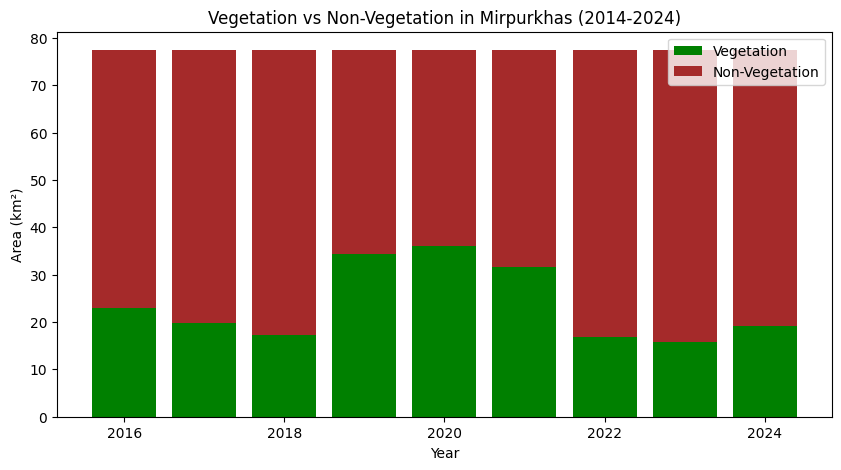

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [9]:
import geemap
import ee
import matplotlib.pyplot as plt

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()

# Create an interactive map
Map = geemap.Map()

# Define Mirpurkhas' region of interest (ROI)
mirpurkhas = ee.Geometry.Point(69.0111, 25.5250).buffer(5000)  # 5 km buffer around Mirpurkhas

# Define time range for 10 years (2014-2024)
years = list(range(2014, 2025))
valid_years = []
vegetation_areas = []
non_vegetation_areas = []

for year in years:
    # Select dataset: Use S2 for early years, S2_SR for recent years
    dataset = "COPERNICUS/S2" if year < 2019 else "COPERNICUS/S2_SR"

    # Load Sentinel-2 dataset (for NDVI)
    ndvi_dataset = ee.ImageCollection(dataset) \
        .filterDate(f'{year}-03-01', f'{year}-05-01') \
        .filterBounds(mirpurkhas) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  # Allow more cloud coverage

    # Select the median image from the period
    image = ndvi_dataset.median()

    # Ensure required bands are available
    band_names = image.bandNames().getInfo()
    if 'B8' not in band_names or 'B4' not in band_names:
        print(f"Year {year}: Required bands not available, skipping...")
        continue  # Skip this year if bands are missing

    # Calculate NDVI using (NIR - Red) / (NIR + Red)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Classify vegetation and non-vegetation based on NDVI threshold
    vegetation = ndvi.gte(0.2)  # Pixels with NDVI >= 0.2 are considered vegetation
    non_vegetation = ndvi.lt(0.2)  # Pixels with NDVI < 0.2 are considered non-vegetation

    # Calculate area of vegetation and non-vegetation
    area_vegetation = vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=mirpurkhas,
        scale=30,
        maxPixels=1e13
    )

    area_non_vegetation = non_vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=mirpurkhas,
        scale=30,
        maxPixels=1e13
    )

    veg_area = area_vegetation.get('NDVI').getInfo() / 1e6  # Convert to square kilometers
    non_veg_area = area_non_vegetation.get('NDVI').getInfo() / 1e6  # Convert to square kilometers

    valid_years.append(year)  # Store only years with data
    vegetation_areas.append(veg_area)
    non_vegetation_areas.append(non_veg_area)

    print(f"Year {year}: Vegetation Area = {veg_area:.2f} km², Non-Vegetation Area = {non_veg_area:.2f} km²")

# Plot results in a bar graph
plt.figure(figsize=(10, 5))
plt.bar(valid_years, vegetation_areas, color='green', label='Vegetation')
plt.bar(valid_years, non_vegetation_areas, bottom=vegetation_areas, color='brown', label='Non-Vegetation')
plt.xlabel("Year")
plt.ylabel("Area (km²)")
plt.title("Vegetation vs Non-Vegetation in Mirpurkhas (2014-2024)")
plt.legend()
plt.show()

# Display the map
Map


### Miurpukhas New Section

Year 2014: Required bands not available, skipping...
Year 2015: Required bands not available, skipping...
Year 2016: Vegetation Area = 22.89 km², Non-Vegetation Area = 54.56 km²
Year 2017: Vegetation Area = 19.72 km², Non-Vegetation Area = 57.72 km²
Year 2018: Vegetation Area = 17.23 km², Non-Vegetation Area = 60.22 km²
Year 2019: Vegetation Area = 34.43 km², Non-Vegetation Area = 43.01 km²
Year 2020: Vegetation Area = 35.96 km², Non-Vegetation Area = 41.49 km²
Year 2021: Vegetation Area = 31.71 km², Non-Vegetation Area = 45.73 km²
Year 2022: Vegetation Area = 16.93 km², Non-Vegetation Area = 60.52 km²
Year 2023: Vegetation Area = 15.71 km², Non-Vegetation Area = 61.74 km²
Year 2024: Vegetation Area = 19.21 km², Non-Vegetation Area = 58.23 km²


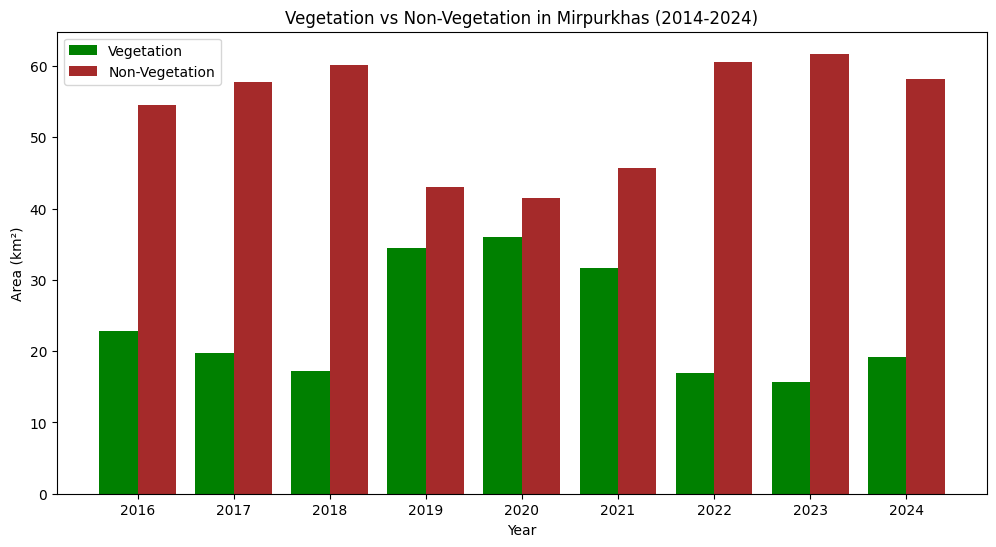

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [10]:
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()


# Create an interactive map
Map = geemap.Map()

# Define Mirpurkhas' region of interest (ROI)
mirpurkhas = ee.Geometry.Point(69.0111, 25.5250).buffer(5000)  # 5 km buffer around Mirpurkhas

# Define time range for 10 years (2014-2024)
years = list(range(2014, 2025))
valid_years = []
vegetation_areas = []
non_vegetation_areas = []

for year in years:
    # Select dataset: Use S2 for early years, S2_SR for recent years
    dataset = "COPERNICUS/S2" if year < 2019 else "COPERNICUS/S2_SR"

    # Load Sentinel-2 dataset (for NDVI)
    ndvi_dataset = ee.ImageCollection(dataset) \
        .filterDate(f'{year}-03-01', f'{year}-05-01') \
        .filterBounds(mirpurkhas) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  # Allow more cloud coverage

    # Select the median image from the period
    image = ndvi_dataset.median()

    # Ensure required bands are available
    band_names = image.bandNames().getInfo()
    if 'B8' not in band_names or 'B4' not in band_names:
        print(f"Year {year}: Required bands not available, skipping...")
        continue  # Skip this year if bands are missing

    # Calculate NDVI using (NIR - Red) / (NIR + Red)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Classify vegetation and non-vegetation based on NDVI threshold
    vegetation = ndvi.gte(0.2)  # Pixels with NDVI >= 0.2 are considered vegetation
    non_vegetation = ndvi.lt(0.2)  # Pixels with NDVI < 0.2 are considered non-vegetation

    # Calculate area of vegetation and non-vegetation
    area_vegetation = vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=mirpurkhas,
        scale=30,
        maxPixels=1e13
    )

    area_non_vegetation = non_vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=mirpurkhas,
        scale=30,
        maxPixels=1e13
    )

    veg_area = area_vegetation.get('NDVI').getInfo() / 1e6  # Convert to square kilometers
    non_veg_area = area_non_vegetation.get('NDVI').getInfo() / 1e6  # Convert to square kilometers

    valid_years.append(year)  # Store only years with data
    vegetation_areas.append(veg_area)
    non_vegetation_areas.append(non_veg_area)

    print(f"Year {year}: Vegetation Area = {veg_area:.2f} km², Non-Vegetation Area = {non_veg_area:.2f} km²")

# Plot results in a bar graph with separated bars
plt.figure(figsize=(12, 6))
bar_width = 0.4  # Width of the bars
x_indexes = np.arange(len(valid_years))

plt.bar(x_indexes - bar_width/2, vegetation_areas, bar_width, color='green', label='Vegetation')
plt.bar(x_indexes + bar_width/2, non_vegetation_areas, bar_width, color='brown', label='Non-Vegetation')

plt.xlabel("Year")
plt.ylabel("Area (km²)")
plt.title("Vegetation vs Non-Vegetation in Mirpurkhas (2014-2024)")
plt.xticks(ticks=x_indexes, labels=valid_years)
plt.legend()
plt.show()

# Display the map
Map


Year 2014: Required bands not available, skipping...
Year 2015: Required bands not available, skipping...
Year 2016: Vegetation Area = 29.00 km², Non-Vegetation Area = 48.47 km²
Year 2017: Vegetation Area = 14.54 km², Non-Vegetation Area = 62.94 km²
Year 2018: Vegetation Area = 22.28 km², Non-Vegetation Area = 55.20 km²
Year 2019: Vegetation Area = 36.72 km², Non-Vegetation Area = 40.76 km²
Year 2020: Vegetation Area = 34.90 km², Non-Vegetation Area = 42.58 km²
Year 2021: Vegetation Area = 31.55 km², Non-Vegetation Area = 45.93 km²
Year 2022: Vegetation Area = 24.17 km², Non-Vegetation Area = 53.31 km²
Year 2023: Vegetation Area = 16.32 km², Non-Vegetation Area = 61.16 km²
Year 2024: Vegetation Area = 29.30 km², Non-Vegetation Area = 48.18 km²


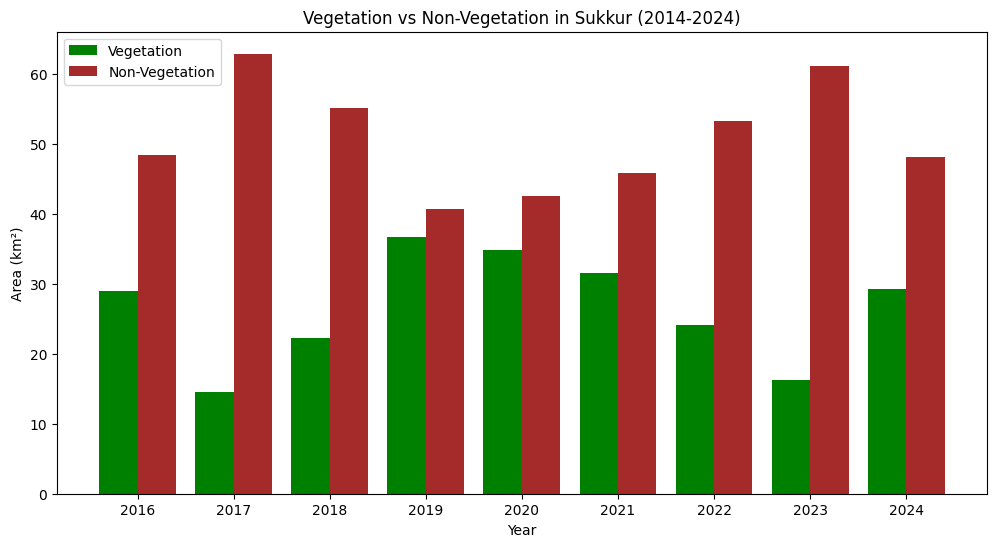

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [11]:
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()

# Create an interactive map
Map = geemap.Map()

# Define Sukkur's region of interest (ROI)
sukkur = ee.Geometry.Point(68.8574, 27.7139).buffer(5000)  # 5 km buffer around Sukkur

# Define time range for 10 years (2014-2024)
years = list(range(2014, 2025))
valid_years = []
vegetation_areas = []
non_vegetation_areas = []

for year in years:
    # Select dataset: Use S2 for early years, S2_SR for recent years
    dataset = "COPERNICUS/S2" if year < 2019 else "COPERNICUS/S2_SR"

    # Load Sentinel-2 dataset (for NDVI)
    ndvi_dataset = ee.ImageCollection(dataset) \
        .filterDate(f'{year}-03-01', f'{year}-05-01') \
        .filterBounds(sukkur) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30))  # Allow more cloud coverage

    # Select the median image from the period
    image = ndvi_dataset.median()

    # Ensure required bands are available
    band_names = image.bandNames().getInfo()
    if 'B8' not in band_names or 'B4' not in band_names:
        print(f"Year {year}: Required bands not available, skipping...")
        continue  # Skip this year if bands are missing

    # Calculate NDVI using (NIR - Red) / (NIR + Red)
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')

    # Classify vegetation and non-vegetation based on NDVI threshold
    vegetation = ndvi.gte(0.2)  # Pixels with NDVI >= 0.2 are considered vegetation
    non_vegetation = ndvi.lt(0.2)  # Pixels with NDVI < 0.2 are considered non-vegetation

    # Calculate area of vegetation and non-vegetation
    area_vegetation = vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=sukkur,
        scale=30,
        maxPixels=1e13
    )

    area_non_vegetation = non_vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=sukkur,
        scale=30,
        maxPixels=1e13
    )

    veg_area = area_vegetation.get('NDVI').getInfo() / 1e6  # Convert to square kilometers
    non_veg_area = area_non_vegetation.get('NDVI').getInfo() / 1e6  # Convert to square kilometers

    valid_years.append(year)  # Store only years with data
    vegetation_areas.append(veg_area)
    non_vegetation_areas.append(non_veg_area)

    print(f"Year {year}: Vegetation Area = {veg_area:.2f} km², Non-Vegetation Area = {non_veg_area:.2f} km²")

# Plot results in a bar graph with separated bars
plt.figure(figsize=(12, 6))
bar_width = 0.4  # Width of the bars
x_indexes = np.arange(len(valid_years))

plt.bar(x_indexes - bar_width/2, vegetation_areas, bar_width, color='green', label='Vegetation')
plt.bar(x_indexes + bar_width/2, non_vegetation_areas, bar_width, color='brown', label='Non-Vegetation')

plt.xlabel("Year")
plt.ylabel("Area (km²)")
plt.title("Vegetation vs Non-Vegetation in Sukkur (2014-2024)")
plt.xticks(ticks=x_indexes, labels=valid_years)
plt.legend()
plt.show()

# Display the map
Map


In [14]:
import geemap
import ee
import matplotlib.pyplot as plt
import numpy as np

# Authenticate and initialize Earth Engine
try:
    ee.Initialize()
except:
    ee.Authenticate()

# Create an interactive map
Map = geemap.Map()

# Define Mirpurkhas' region of interest (ROI)
mirpurkhas = ee.Geometry.Point(69.0111, 25.5250).buffer(5000)  # 5 km buffer around Mirpurkhas

# Define time range for 10 years (2014-2024)
years = list(range(2014, 2025))
valid_years = []
vegetation_areas = []
non_vegetation_areas = []

for year in years:
    if year < 2019:
        dataset = "LANDSAT/LC08/C02/T1_L2"  # Updated to Landsat 8 Collection 2 SR
        nir_band, red_band = 'SR_B5', 'SR_B4'  # Landsat 8 Collection 2 bands
    else:
        dataset = "COPERNICUS/S2_SR"  # Use Sentinel-2 for recent years
        nir_band, red_band = 'B8', 'B4'  # Sentinel-2 bands

    # Load dataset with cloud filtering
    def mask_clouds(image):
        if year < 2019:
            cloud_mask = image.select('QA_PIXEL').bitwiseAnd(1 << 3).eq(0)  # Landsat Collection 2 cloud mask
        else:
            qa60 = image.select(['QA60'])  # Sentinel-2 cloud mask band
            cloud_mask = qa60.bitwiseAnd(1 << 10).eq(0)  # Keep cloud-free pixels
        return image.updateMask(cloud_mask)

    ndvi_dataset = ee.ImageCollection(dataset) \
        .filterDate(f'{year}-03-01', f'{year}-05-01') \
        .filterBounds(mirpurkhas) \
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))

    # Apply cloud masking and select median image
    image = ndvi_dataset.map(mask_clouds).median()

    # Ensure required bands are available
    band_names = image.bandNames().getInfo()
    if nir_band not in band_names or red_band not in band_names:
        print(f"Year {year}: Required bands not available, skipping...")
        continue

    # Calculate NDVI using (NIR - Red) / (NIR + Red)
    ndvi = image.normalizedDifference([nir_band, red_band]).rename('NDVI')

    # Classify vegetation and non-vegetation based on NDVI threshold
    vegetation = ndvi.gte(0.2)
    non_vegetation = ndvi.lt(0.2)

    # Calculate area of vegetation and non-vegetation
    area_vegetation = vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=mirpurkhas,
        scale=30,
        maxPixels=1e13
    )

    area_non_vegetation = non_vegetation.multiply(ee.Image.pixelArea()).reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=mirpurkhas,
        scale=30,
        maxPixels=1e13
    )

    veg_area = area_vegetation.get('NDVI').getInfo() / 1e6  # Convert to square kilometers
    non_veg_area = area_non_vegetation.get('NDVI').getInfo() / 1e6  # Convert to square kilometers

    valid_years.append(year)
    vegetation_areas.append(veg_area)
    non_vegetation_areas.append(non_veg_area)

    print(f"Year {year}: Vegetation Area = {veg_area:.2f} km², Non-Vegetation Area = {non_veg_area:.2f} km²")

# Plot results in a bar graph with separated bars
plt.figure(figsize=(12, 6))
bar_width = 0.4
x_indexes = np.arange(len(valid_years))

plt.bar(x_indexes - bar_width/2, vegetation_areas, bar_width, color='green', label='Vegetation')
plt.bar(x_indexes + bar_width/2, non_vegetation_areas, bar_width, color='brown', label='Non-Vegetation')

plt.xlabel("Year")
plt.ylabel("Area (km²)")
plt.title("Vegetation vs Non-Vegetation in Mirpurkhas (2014-2024) - Clear Imagery")
plt.xticks(ticks=x_indexes, labels=valid_years)
plt.legend()
plt.show()

# Display the map
Map

Year 2014: Required bands not available, skipping...
Year 2015: Required bands not available, skipping...
Year 2016: Required bands not available, skipping...
Year 2017: Required bands not available, skipping...
Year 2018: Required bands not available, skipping...
Year 2019: Vegetation Area = 34.66 km², Non-Vegetation Area = 42.78 km²
Year 2020: Vegetation Area = 40.64 km², Non-Vegetation Area = 36.81 km²
Year 2021: Vegetation Area = 32.22 km², Non-Vegetation Area = 45.23 km²
Year 2022: Vegetation Area = 17.49 km², Non-Vegetation Area = 59.95 km²
Year 2023: Vegetation Area = 17.91 km², Non-Vegetation Area = 59.54 km²


EEException: reduce.median: Error in map(ID=20240303T055741_20240303T055930_T42RWP):
Image.select: Band pattern 'QA60' did not match any bands. Available bands: [B1, B2, B3, B4, B5, B6, B7, B8, B8A, B9, B11, B12, AOT, WVP, SCL, TCI_R, TCI_G, TCI_B, MSK_CLDPRB, MSK_SNWPRB, MSK_CLASSI_OPAQUE, MSK_CLASSI_CIRRUS, MSK_CLASSI_SNOW_ICE]